In [2]:
import sys
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [3]:
fitter_path = "/home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter"
sys.path.append(fitter_path)
from pi0fit.pi0_model import BinnedPi0Model
from pi0fit.fitter_utilities import spherical_dot

with open(fitter_path +"/config.json", 'r') as f:
        config = json.load(f)

config["binned_pi0_model"]["charge_hist_file"]= fitter_path + "/etc/mean_variance_hist_single_gamma_pdf_rotated_cdist_3d_wzero_50_1200.pkl"
config["binned_pi0_model"]["direction_hist_file"]= fitter_path + "/etc/hist_single_gamma_direction_pdf_rotated_cdist_3d.pkl"
pi0_model = BinnedPi0Model(config=config)

Using GPU: True
Loaded QHist file: /home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/etc/mean_variance_hist_single_gamma_pdf_rotated_cdist_3d_wzero_50_1200.pkl
QHist Bins (20, 20, 20)
Loaded DirHist file: /home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/etc/hist_single_gamma_direction_pdf_rotated_cdist_3d.pkl
DirHist Bins (40, 40, 40)
Random Hist (50, 20, 20, 20)


In [4]:
def oaprob(oa, ep):
    return pi0_model.dn_dalpha_distribution_mod(oa,ep)

def get_shower_oa_mask(fit_values, truth_values, thresh):
    oa_idx = -4 # is -1 for most saved runs
    oa_list = [-np.log(oaprob(np.radians(fit[oa_idx]), fit[0]) + 1.e-200) for energy, fit in zip(truth_values[:,0], fit_values)]
        
    return (np.asarray(oa_list) < thresh) #& (fit_values[:,-4] < 80)

def gaussian(x, cen, wid, amp):
    return amp * np.exp(-(x - cen) ** 2 / (2 * wid ** 2))


def norm_gaussian(x, cen, wid, amp):
    wid = abs(wid)
    return (1. / (wid * np.sqrt(2. * np.pi))) * np.exp(-(x - cen) ** 2 / (2 * wid ** 2))


def fit_gaussian_width(hist, bin_edges, label, color, height_frac, text_y, down=-1, up=1, axes=None):

    ax = plt if axes is None else axes
        
    half_height_mask = hist >= np.max(hist) * height_frac
    # print(half_height_mask)

    # Fit the histogram data with the Gaussian function
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    popt, pcov = curve_fit(gaussian, bin_centers[half_height_mask],
                           hist[half_height_mask] / np.max(hist[half_height_mask]))
    print("μ", popt[0], "σ", popt[1])

    x = np.linspace(down, up, 200)
    y = norm_gaussian(x, *popt) / 1.2
    ax.plot(x, np.max(hist) * (y / np.max(y)), linestyle='--', label=label, color=color)
    ax.text(0, 0.9*np.max(hist), label + "    $\\mu$ = " + str(round(popt[0], 4)) + "  $\\sigma$ = " + str(round(popt[1], 4)),
             fontsize=12)

def integrate_1d(hist, bins):
    binwidth0 = bins[1] - bins[0]
    return np.sum(hist * binwidth0, axis=0)


In [5]:
d['efficiency']

NameError: name 'd' is not defined

In [6]:
# file_list = !ls /home/jon/work/protodune/analysis/pi0_reco/batch/1gev_run_normal_dnda_old_fv/fit_result_*.pickle
file_list = !ls /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old_fv/fit_result_*.pickle
# print(file_list)

comp_list = []
fit_vals_list = []
truth_vals_list = []
total_evts = 0
for res_file in file_list:
    with open(res_file, 'rb') as f:
        d = pickle.load(f)
    nevts = float(len(d['fit_results'])) / d['efficiency'][0]
    total_evts += nevts
    print("ϵ:", np.round(d['efficiency'],3), "nEvts:", nevts, " file:", res_file)
    for fv, tv, comp in zip(d['fit_results'], d['truth_list'], d['comparison']):
        comp_list.append(comp)
        fit_vals_list.append(fv)
        truth_vals_list.append(tv)


comparison = np.asarray(comp_list)
fit_values = np.asarray(fit_vals_list)
truth_values = np.asarray(truth_vals_list)

cos_cut = 0.9
correct_shower_dir = (comparison[:,-2] > cos_cut) & (comparison[:,-1] > cos_cut)
print("Total nEvts:", total_evts)
print(np.count_nonzero(correct_shower_dir), "/", len(comp_list), "=", np.count_nonzero(correct_shower_dir) / len(comp_list))

true_cos = comparison[:,1] + fit_values[:,1]
reco_true_direction = np.cos(np.abs(np.arccos(true_cos) - np.arccos(fit_values[:,1])))
reco_minus_true_theta = np.degrees(np.arccos(fit_values[:,1]) - np.arccos(true_cos))

ϵ: [0.776] nEvts: 237.0  file: /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old_fv/fit_result_0.pickle
ϵ: [0.797] nEvts: 207.0  file: /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old_fv/fit_result_1.pickle
ϵ: [0.782] nEvts: 202.0  file: /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old_fv/fit_result_2.pickle
ϵ: [0.816] nEvts: 185.0  file: /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old_fv/fit_result_3.pickle
ϵ: [0.828] nEvts: 192.0  file: /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old_fv/fit_result_4.pickle
ϵ: [0.849] nEvts: 212.0  file: /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old_fv/fit_result_5.pickle
ϵ: [0.845] nEvts: 220.0  file: /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old_fv/fit_result_7.pickle
ϵ: [0.823] nEvts: 232.0  file: /home/jon/work/protodune/analysis/pi0_reco/batch/2gev_run_normal_dnda_old

/tmp/ipykernel_61793/3893669549.py:31: RuntimeWarning: invalid value encountered in arccos
  reco_true_direction = np.cos(np.abs(np.arccos(true_cos) - np.arccos(fit_values[:,1])))
/tmp/ipykernel_61793/3893669549.py:32: RuntimeWarning: invalid value encountered in arccos
  reco_minus_true_theta = np.degrees(np.arccos(fit_values[:,1]) - np.arccos(true_cos))


In [7]:
def plot_xsec_variables(fit_values, truth_values, comparison, reco_minus_true_theta, mask=None):

    sel_mask = np.ones(len(comparison), dtype=bool) if mask is None else mask

    v1 = np.vstack((np.ones(shape=truth_values[:,1][sel_mask].shape), np.arccos(truth_values[:,1][sel_mask]), np.zeros(shape=truth_values[:,1][sel_mask].shape)))
    v2 = np.vstack((np.ones(shape=fit_values[:,1][sel_mask].shape), np.arccos(fit_values[:,1][sel_mask]), np.zeros(shape=fit_values[:,1][sel_mask].shape)))
    # true_dot_reco = spherical_dot(v1.T, v2.T)

    true_dot_reco = np.sin(np.arccos(truth_values[:,1][sel_mask])) * np.sin(fit_values[:,1][sel_mask]) + np.cos(np.arccos(truth_values[:,1][sel_mask])) * np.cos(fit_values[:,1][sel_mask])
    
    _,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
    bins = 40
    shift = ((2./bins)/2.)
    c,bx,_=ax1.hist(comparison[:,0][sel_mask], bins=bins, range=[-1+shift,1+shift])
    fit_gaussian_width(hist=c, bin_edges=bx, label='', color='red', height_frac=0.3, text_y=48.5, down=-0.9, up=0.9, axes=ax1)
    ax1.set_xlabel("$E_{\\pi^0}:$  $Fit/True - 1$", fontsize=12)
    ax1.set_xticks(np.arange(-1, 1.2, 0.2))
    
    bins = 40
    shift = ((2./bins)/2.)
    # c,bx,_=ax2.hist(reco_minus_true_theta[sel_mask], range=(-50+shift,50+shift), bins=bins, density=False)
    c,bx,_=ax2.hist(true_dot_reco, range=(-1+shift,1+shift), bins=bins, density=False)
    # fit_gaussian_width(hist=c, bin_edges=bx, label='', color='red', height_frac=0.3, text_y=20, down=-50, up=50, axes=ax2)
    ax2.set_xlabel("$True \\theta_{\pi^0} \circ Fit \\theta_{\pi^0}$", fontsize=12)
    ax2.set_xticks(np.arange(-1, 1.2, 0.2))
    
    plt.show()

def plot_xsec_variable_2d(fit_values, truth_values, comparison, reco_minus_true_theta, mask=None):

    xbins = 30
    ybins = 30
    sel_mask = np.ones(len(comparison), dtype=bool) if mask is None else mask

    epi0_up = 2000 if np.max(truth_values[:,0]) > 1500 else 1000
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
    bins = 40
    shift = ((2./bins)/2.)
    _,_,_,f=ax1.hist2d(truth_values[:,0][sel_mask], comparison[:,0][sel_mask], range=[[0,epi0_up],[-1.+shift,1.+shift]], bins=[xbins,ybins], cmin=1, cmap=plt.cm.jet)
    ax1.plot([0,epi0_up+100],[0,0], color='gray', linestyle='--')
    ax1.set_xticks(np.arange(0, epi0_up+100, 200))
    ax1.set_yticks(np.arange(-1, 1.2, 0.2))
    plt.colorbar(f)
    ax1.set_xlabel("True $E_{\\pi^0}$ [MeV]", fontsize=12)
    ax1.set_ylabel("$E_{\\pi^0}:$  $Fit/True - 1$", fontsize=12)

    xbins = 30
    ybins = 50
    shift = ((100./bins)/2.)
    _,_,_,f=ax2.hist2d(truth_values[:,0][sel_mask], reco_minus_true_theta[sel_mask], range=((0,epi0_up),(-50+shift,50+shift)), bins=[xbins,ybins], cmap=plt.cm.jet, cmin=1)
    # _,_,_,f=ax2.hist2d(fit_values[:,1][sel_mask], reco_minus_true_theta[sel_mask], range=((-1,1),(-50+shift,50+shift)), bins=[xbins,ybins], cmap=plt.cm.jet, cmin=1)
    ax2.plot([0,epi0_up+100],[0,0], color='gray', linestyle='--')
    ax1.set_xlabel("True $E_{\\pi^0}$ [MeV]", fontsize=12)
    # ax2.set_xlabel("True $cos\\theta_{\\pi^0}$", fontsize=12)
    ax2.set_ylabel("$\\theta_{fit} - \\theta_{true}$ [deg]", fontsize=12)
    ax1.set_xticks(np.arange(0, epi0_up+100, 200))
    ax2.set_yticks(np.arange(-50, 60, 10))
    plt.colorbar(f)
    plt.show()

def plot_xsec_efficiency(truth_values, mask=None, bins=20):

    sel_mask = np.ones(len(comparison), dtype=bool) if mask is None else mask
    epi0_up = 2000 if np.max(truth_values[:,0]) > 1500 else 1000
    
    fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16,4))
    c1,bx,_=ax1.hist(truth_values[:,0], range=[135, epi0_up], bins=bins, color='royalblue', density=False, label='All $E_{\\pi^0}$')
    c2,bx,_=ax1.hist(truth_values[:,0][sel_mask], range=[135, epi0_up], bins=bins, color='mediumorchid', density=False, label='Fit $E_{\\pi^0}$')
    bc = (bx[0:-1] + bx[1:]) / 2.
    ax1.set_xlim(0,epi0_up)
    ax1.set_xticks(np.arange(0, epi0_up+100, 200))
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    eps = c2 / c1
    ax2.plot(bc, eps, color='black', linestyle='--', label='Fit $\epsilon$')
    ax1.set_xlabel("True $E_{\\pi^0}$ [MeV]", fontsize=12)
    ax2.set_ylabel("Efficiency", fontsize=12)
    uncertainty = 1. / np.sqrt(c2)
    uncertainty[uncertainty < 0] = 0
    uncertainty_low, uncertainty_high = eps - uncertainty, eps + uncertainty
    uncertainty_low[uncertainty_low < 0] = 0
    uncertainty_high[uncertainty_high > 1] = 1
    ax2.set_ylim(0,1)
    ax2.legend(loc='upper right')
    # plt.grid()
    
    ########################################
    
    c1,bx,_=ax3.hist(true_cos, range=[-1, 1], bins=bins, color='royalblue', density=False, label='All $cos\\theta_{\\pi^0}$')
    c2,bx,_=ax3.hist(true_cos[sel_mask], range=[-1, 1], bins=bins, color='mediumorchid', density=False, label='Fit $cos\\theta_{\\pi^0}$')
    ax3.set_xticks(np.arange(-1, 1.2, 0.2))
    ax3.set_xlim(-1,1)
    bc = (bx[0:-1] + bx[1:]) / 2.
    ax3.legend(loc='upper left')
    ax4 = ax3.twinx()
    eps = c2 / c1
    ax4.plot(bc, eps, color='black', linestyle='--', label='Fit $\epsilon$')
    ax3.set_xlabel("True $cos\\theta_{\\pi^0}$", fontsize=12)
    ax4.set_ylabel("Efficiency", fontsize=12)
    ax4.set_ylim(0,1)
    ax4.legend(loc='upper right')
    # plt.grid()
    plt.show()

def plot_truth_reco(fit_values, truth_values, mask=None):
    sel_mask = np.ones(len(comparison), dtype=bool) if mask is None else mask
    epi0_up = 2000 if np.max(truth_values[:,0]) > 1500 else 1000
    bins = 20
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4.5))
    _,_,_,f=ax1.hist2d(truth_values[:,0][sel_mask], fit_values[:,0][sel_mask], range=[[0,epi0_up],[0,epi0_up]], bins=bins, cmin=1, cmap=plt.cm.YlGnBu)
    ax1.plot([0,epi0_up],[0,epi0_up], linestyle='--', color='black')
    ax1.set_ylabel("Fit $E_{\\pi^0}$", fontsize=12)
    ax1.set_xlabel("True $E_{\\pi^0}$", fontsize=12)
    step = 200
    ax1.set_xticks(np.arange(0, epi0_up+step, step))
    ax1.set_yticks(np.arange(0, epi0_up+step, step))
    plt.colorbar(f)

    _,_,_,f=ax2.hist2d(truth_values[:,1][sel_mask], fit_values[:,1][sel_mask], range=[[-1,1],[-1,1]], bins=bins, cmin=1, cmap=plt.cm.YlGnBu)
    ax2.plot([-1,1],[-1,1], linestyle='--', color='black')
    ax2.set_ylabel("Fit $cos\\theta_{\\pi^0}$", fontsize=12)
    ax2.set_xlabel("True $cos\\theta_{\\pi^0}$", fontsize=12)
    step = 0.2
    ax2.set_xticks(np.arange(-1, 1+step, step))
    ax2.set_yticks(np.arange(-1, 1+step, step))
    plt.colorbar(f)
    plt.show()

In [8]:
# lh_thresh = -0.3 # 1GeV
lh_thresh = -0.8 # 2GeV

======= Reco All Showers =======
Total nshowers 1539
μ -0.07535626046420024 σ 0.14903392409632787


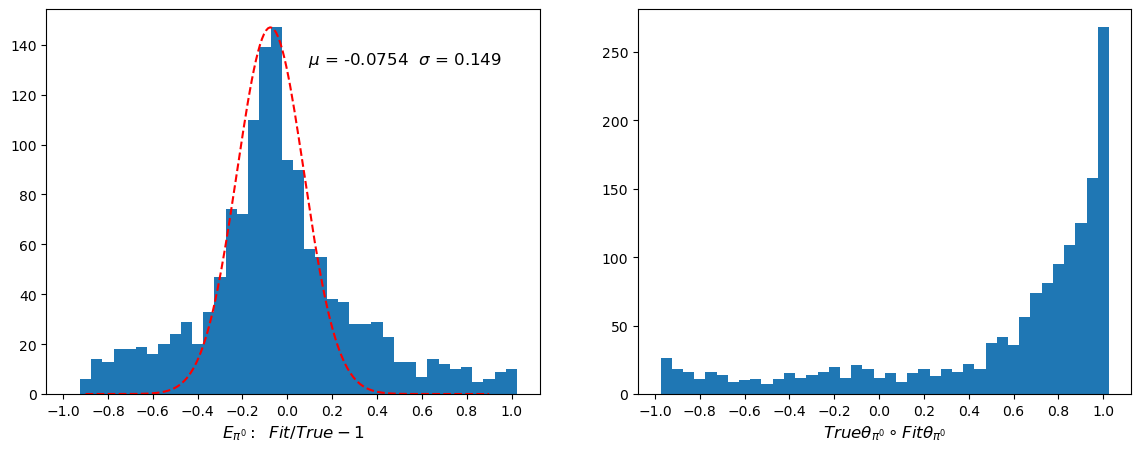

======= Truth Good Shower Selection =======
Correct nshowers 558
μ -0.06045135660720399 σ 0.09879093872219016


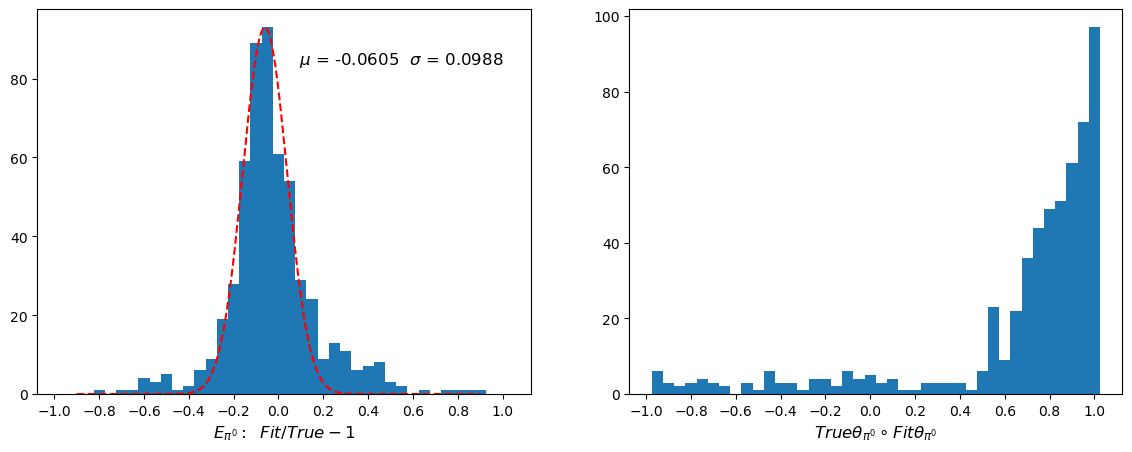

======= Reco Good Shower Selection =======
Correct nshowers 373
Total Selected: 605
Total ϵ: 0.2424  purity: 0.6165
μ -0.050976894992118126 σ 0.09572844377178166


/home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/pi0fit/pi0_model.py:559: RuntimeWarning: invalid value encountered in sqrt
  1 / np.sqrt(gamma ** 2 * np.sin(alpha / 2.) ** 2 - 1))
/home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/pi0fit/pi0_model.py:558: RuntimeWarning: divide by zero encountered in scalar divide
  diff_angle = 2 * (1 / (4. * gamma * beta)) * (np.cos(alpha / 2.) / np.sin(alpha / 2.) ** 2) * (
/home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/pi0fit/pi0_model.py:563: RuntimeWarning: divide by zero encountered in scalar divide
  trans_point = 2 * (1 / (4. * gamma * beta)) * (np.cos(min_alpha / 2.) / np.sin(min_alpha / 2.) ** 2) * (
/home/jon/work/protodune/analysis/pi0_reco/code/pi0_fitter/pi0fit/pi0_model.py:564: RuntimeWarning: invalid value encountered in sqrt
  1 / np.sqrt(gamma ** 2 * np.sin(min_alpha / 2.) ** 2 - 1))


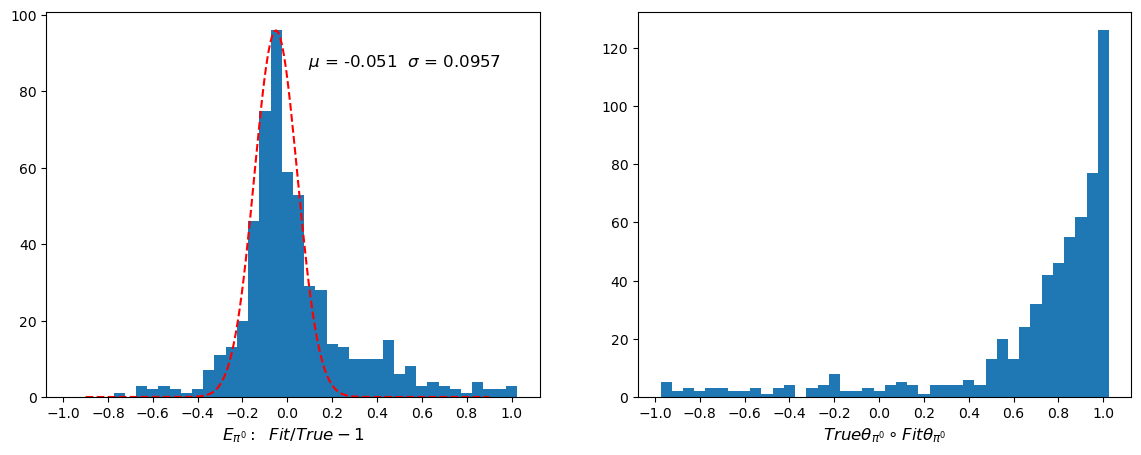

In [9]:
print("======= Reco All Showers =======")
print("Total nshowers", len(comparison))
plot_xsec_variables(fit_values=fit_values, truth_values=truth_values, comparison=comparison, reco_minus_true_theta=reco_minus_true_theta, mask=None)

print("======= Truth Good Shower Selection =======")
print("Correct nshowers", np.count_nonzero(correct_shower_dir))
plot_xsec_variables(fit_values=fit_values, truth_values=truth_values, comparison=comparison, reco_minus_true_theta=reco_minus_true_theta, mask=correct_shower_dir)

shower_mask = get_shower_oa_mask(fit_values=fit_values, truth_values=truth_values, thresh=lh_thresh)
print("======= Reco Good Shower Selection =======")
print("Correct nshowers", np.count_nonzero(correct_shower_dir[shower_mask]))
print("Total Selected:", len(correct_shower_dir[shower_mask]))
print('Total ϵ:', np.round(np.count_nonzero(correct_shower_dir & shower_mask) / len(shower_mask), 4), 
      ' purity:', np.round(np.count_nonzero(correct_shower_dir & shower_mask) / np.count_nonzero(shower_mask), 4))

plot_xsec_variables(fit_values=fit_values, truth_values=truth_values, comparison=comparison, reco_minus_true_theta=reco_minus_true_theta, mask=shower_mask)

======= Reco All Showers =======


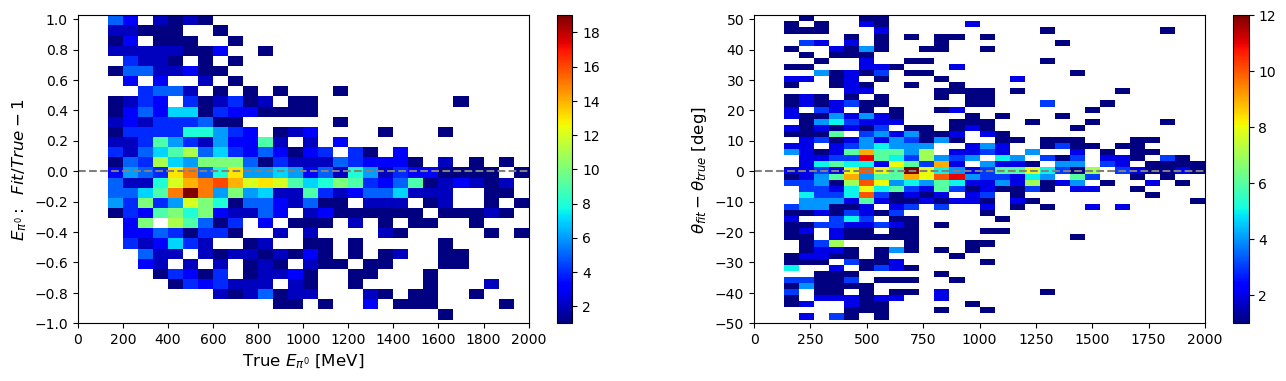

======= Truth Good Shower Selection =======


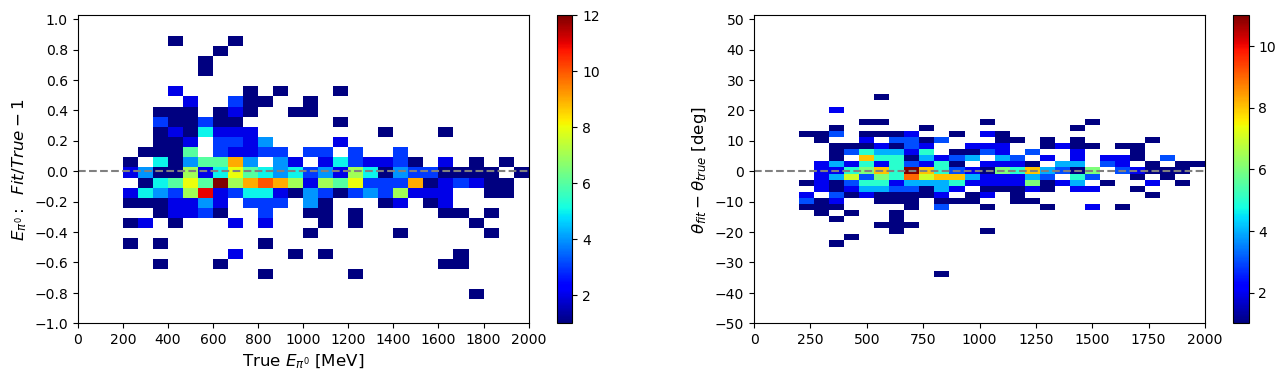

======= Reco Good Shower Selection =======


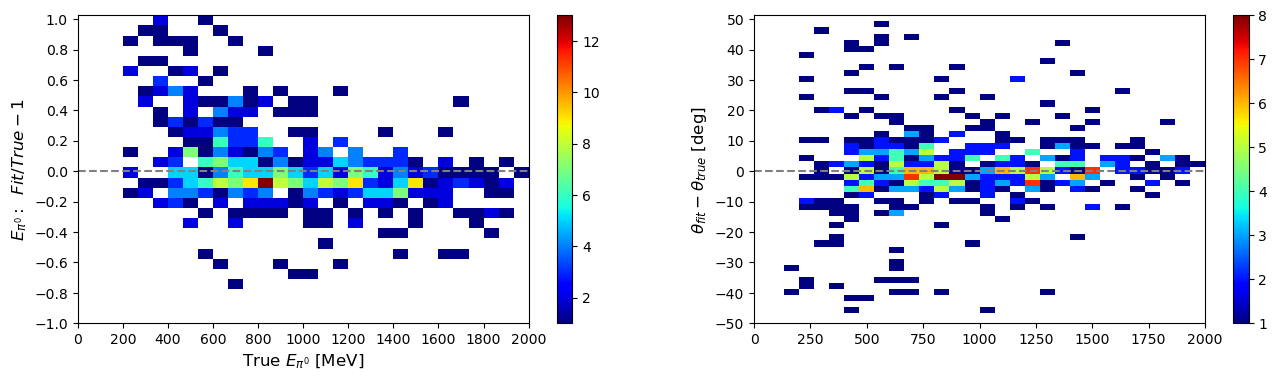

In [10]:
print("======= Reco All Showers =======")
plot_xsec_variable_2d(fit_values=fit_values, truth_values=truth_values, comparison=comparison, reco_minus_true_theta=reco_minus_true_theta, mask=None)

print("======= Truth Good Shower Selection =======")
plot_xsec_variable_2d(fit_values=fit_values, truth_values=truth_values, comparison=comparison, reco_minus_true_theta=reco_minus_true_theta, mask=correct_shower_dir)

print("======= Reco Good Shower Selection =======")
shower_mask = get_shower_oa_mask(fit_values=fit_values, truth_values=truth_values, thresh=lh_thresh)
plot_xsec_variable_2d(fit_values=fit_values, truth_values=truth_values, comparison=comparison, reco_minus_true_theta=reco_minus_true_theta, mask=shower_mask)

======= Truth Good Shower Selection =======


/tmp/ipykernel_61793/650410068.py:79: RuntimeWarning: divide by zero encountered in divide
  uncertainty = 1. / np.sqrt(c2)


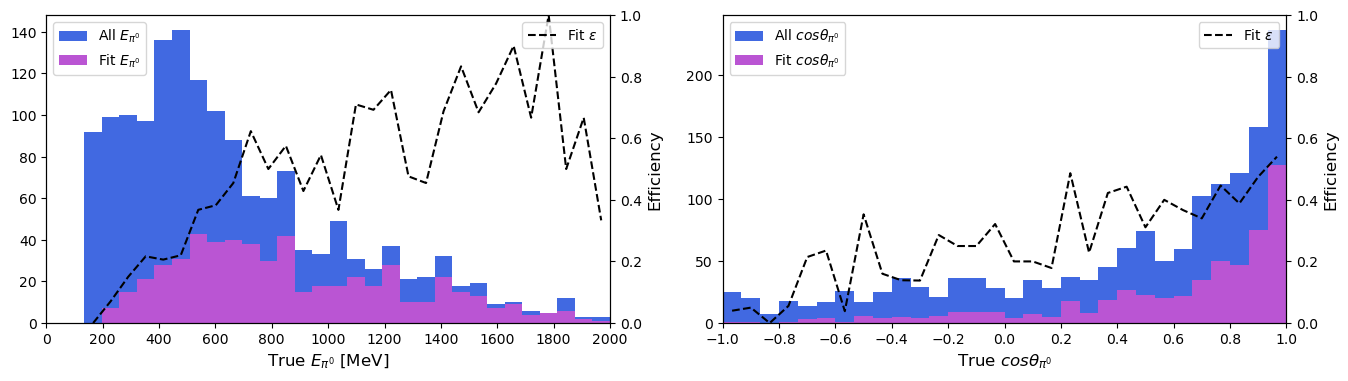

======= Reco Good Shower Selection =======


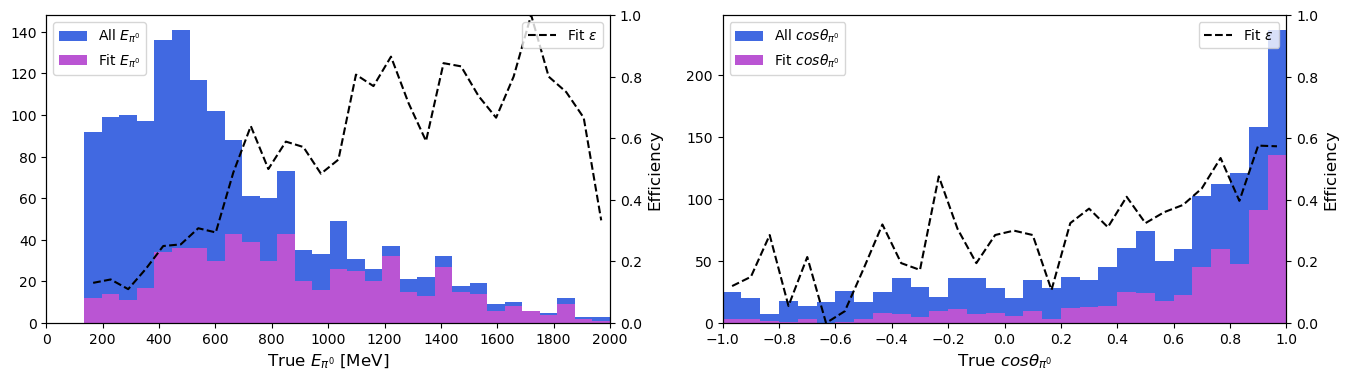

In [11]:
print("======= Truth Good Shower Selection =======")
plot_xsec_efficiency(truth_values=truth_values, mask=correct_shower_dir, bins=30)

print("======= Reco Good Shower Selection =======")
shower_mask = get_shower_oa_mask(fit_values=fit_values, truth_values=truth_values, thresh=lh_thresh)
plot_xsec_efficiency(truth_values=truth_values, mask=shower_mask, bins=30)

======= Reco Good Shower Selection =======


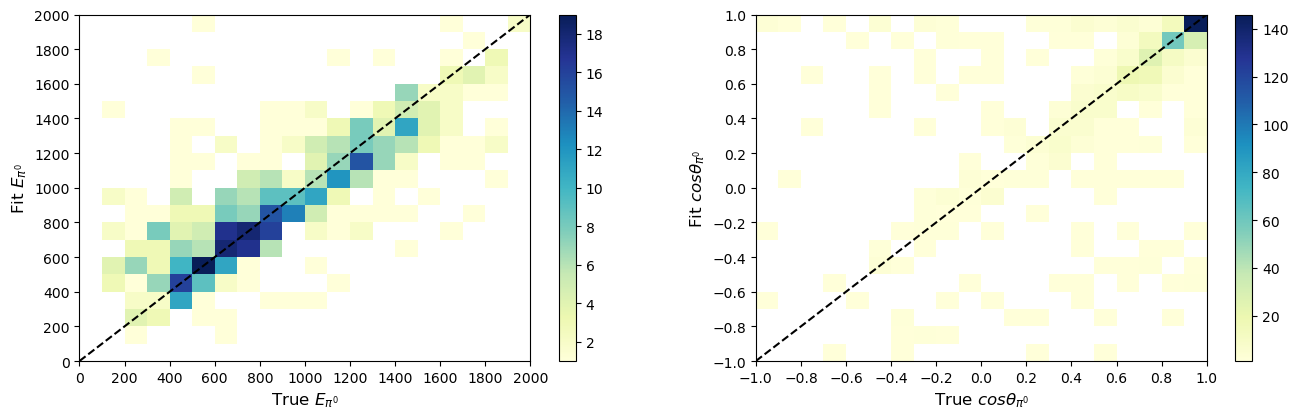

In [12]:
print("======= Reco Good Shower Selection =======")
shower_mask = get_shower_oa_mask(fit_values=fit_values, truth_values=truth_values, thresh=lh_thresh)
plot_truth_reco(fit_values=fit_values, truth_values=truth_values, mask=shower_mask)

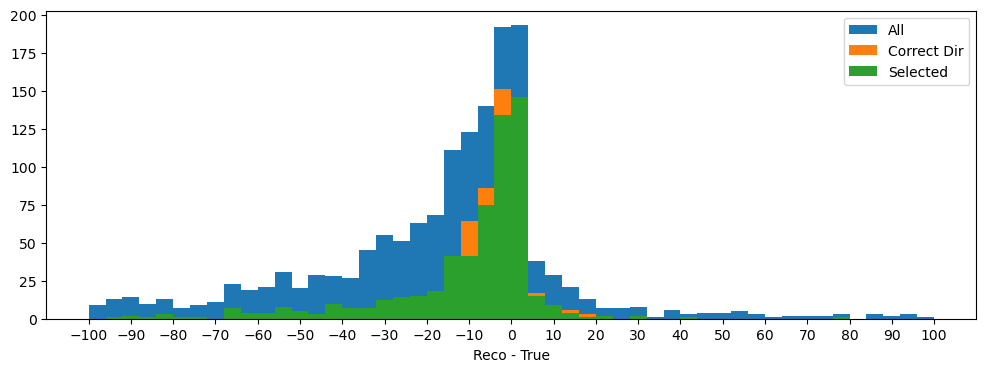

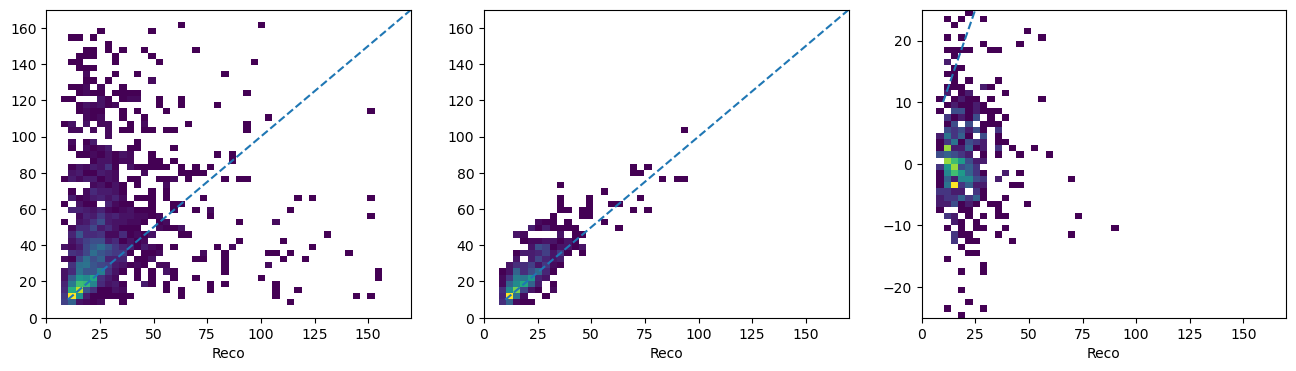

In [13]:
shower_mask = get_shower_oa_mask(fit_values=fit_values, truth_values=truth_values, thresh=lh_thresh)

plt.figure(figsize=(12,4))
plt.hist(fit_values[:,-4] - truth_values[:,-4], range=[-100,100], bins=50, label='All')
plt.hist(fit_values[:,-4][correct_shower_dir] - truth_values[:,-4][correct_shower_dir], range=[-100,100], bins=50, label='Correct Dir')
plt.hist(fit_values[:,-4][shower_mask] - truth_values[:,-4][shower_mask], range=[-100,100], bins=50, label='Selected')
plt.xticks(np.arange(-100,110,10))
plt.xlabel("Reco - True")
plt.legend()
plt.show()

_,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
ax1.hist2d(fit_values[:,-4], truth_values[:,-4], bins=50, range=[[0,170],[0,170]], cmin=1)
ax1.plot([10,170],[10,170], linestyle='--')
ax1.set_xlabel('Reco')

ax2.hist2d(fit_values[:,-4][correct_shower_dir], truth_values[:,-4][correct_shower_dir], bins=50, range=[[0,170],[0,170]], cmin=1)
ax2.plot([10,170],[10,170], linestyle='--')
ax2.set_xlabel('Reco')

# ax3.hist2d(fit_values[:,-4][shower_mask], truth_values[:,-4][shower_mask], bins=50, range=[[0,170],[0,170]], cmin=1)
ax3.hist2d(fit_values[:,-4][shower_mask], reco_minus_true_theta[shower_mask], bins=50, range=[[0,170],[-25,25]], cmin=1)
ax3.plot([10,170],[10,170], linestyle='--')
ax3.set_xlabel('Reco')
plt.show()

In [59]:
div = 225.17959542041763 / 255.01580885921618
div - 1

-0.1169975052616048

In [124]:
g = np.random.normal(1,1,2000)
x = np.random.uniform(0,10,2000)
y = 0.5 * x + 5

(-24.0, 24.0)

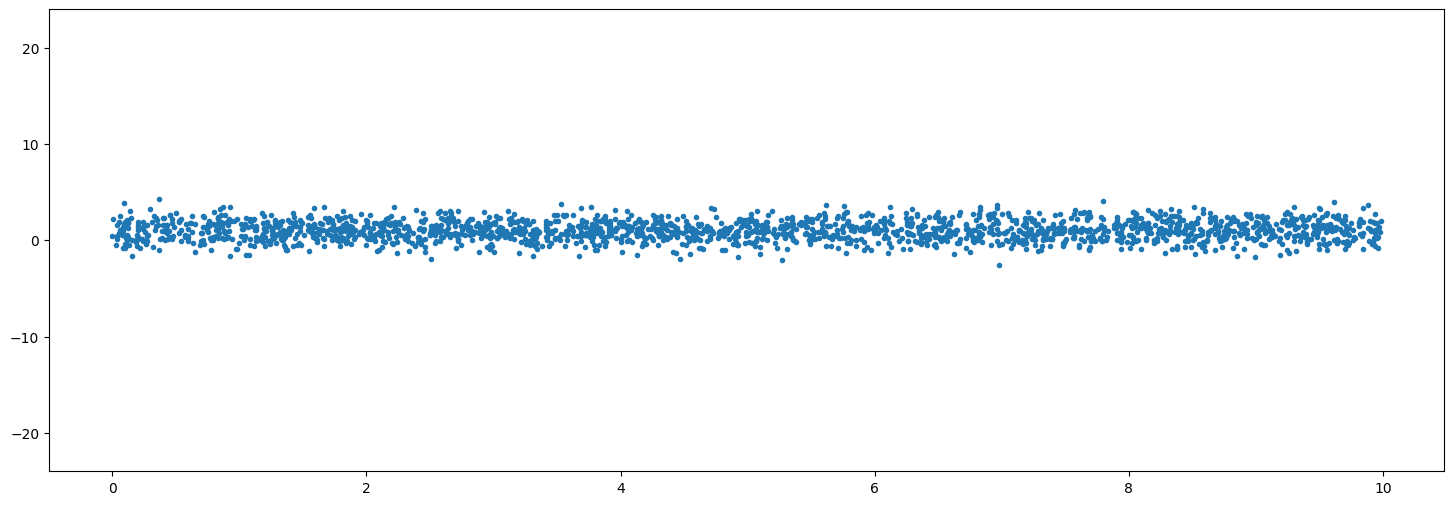

In [125]:
plt.figure(figsize=(18,6))
plt.plot(x,g, linestyle='None', marker='.')
plt.ylim(-24,24)

In [37]:
"""
self.epi0, self.cos_pi0, self.eg1, self.eg2, self.theta1, self.theta2,
self.phi1, self.phi2, np.degrees(self.open_angle), self.c1, self.c2
"""
# fit_values
eg1 = truth_values[:, 2]
eg2 = truth_values[:, 3]
opening_angle = np.radians(truth_values[:, 8])

reco_eg1 = fit_values[:, 2]
reco_eg2 = fit_values[:, 3]
reco_opening_angle = np.radians(fit_values[:, 8])

mgg = np.sqrt(2. * eg1 * eg2 * (1. - np.cos(opening_angle)))
reco_mgg = np.sqrt(2. * reco_eg1 * reco_eg2 * (1. - np.cos(reco_opening_angle)))
print(len(truth_values), "/", len(fit_values))

1539 / 1539


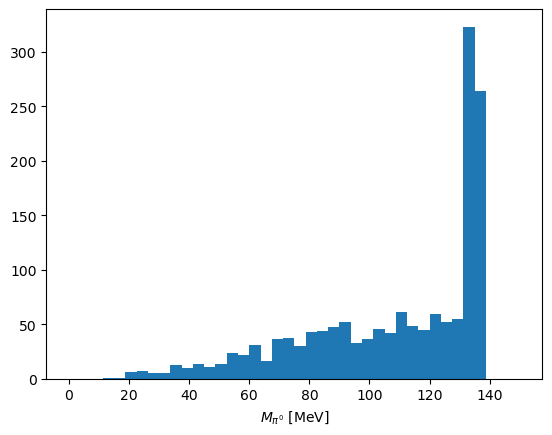

inf


/tmp/ipykernel_61793/1210352799.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  print(c[-4].sum() / c[-3])


In [44]:
c,_,_=plt.hist(reco_mgg, bins=40, range=[0, 150])
plt.xlabel("$M_{\pi^0}$ [MeV]")
plt.show()

print(c[-4].sum() / c[-3])

In [92]:
# epi_bias = (fit_values[:, 0] - truth_values[:, 0])
# e1_bias = (reco_eg1 - eg1)#(reco_eg1 / eg1) - 1
# e2_bias = (reco_eg2 - eg2)#(reco_eg2 / eg2) - 1
oa_bias = (fit_values[:, 8] - truth_values[:, 8]) 

epi_bias = (fit_values[:, 0] / truth_values[:, 0]) - 1
e1_bias = (reco_eg1 / eg1) - 1
e2_bias = (reco_eg2 / eg2) - 1

len(oa_bias)

1539

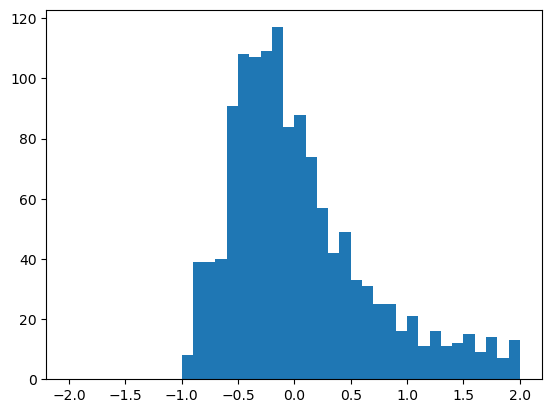

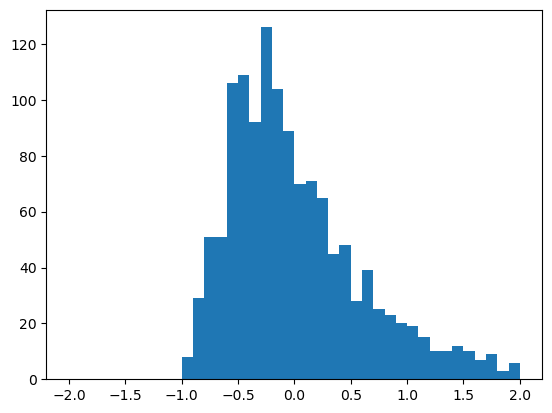

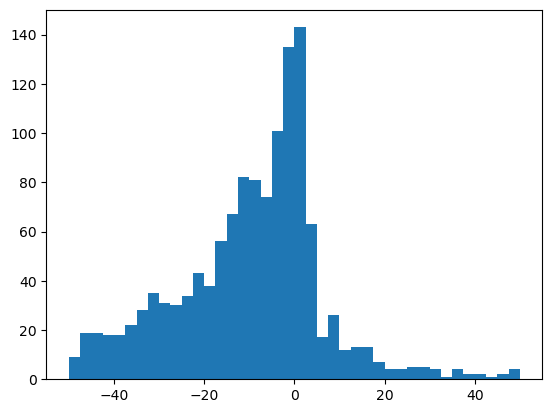

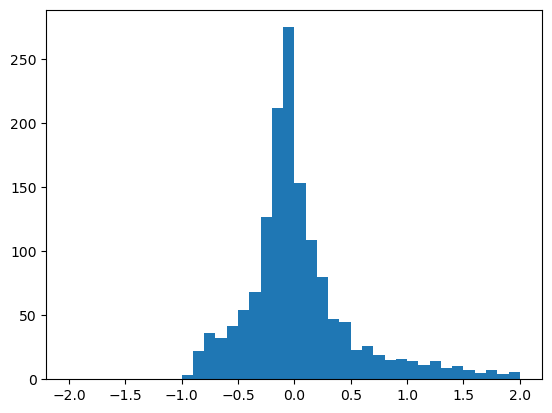

In [93]:
plt.hist(e1_bias, range=[-2, 2], bins=40)
plt.show()

plt.hist(e2_bias, range=[-2, 2], bins=40)
plt.show()

plt.hist(oa_bias, range=[-50, 50], bins=40)
plt.show()

plt.hist(epi_bias, range=[-2, 2], bins=40)
plt.show()

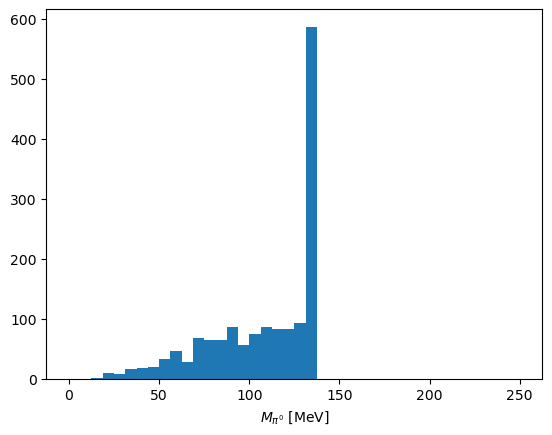

In [106]:
test_mgg = np.sqrt(2. * reco_eg1 * reco_eg2 * (1. - np.cos(reco_opening_angle)))
c,_,_=plt.hist(test_mgg, bins=40, range=[0, 250])
plt.xlabel("$M_{\pi^0}$ [MeV]")
plt.show()

In [83]:
for i in range(len(reco_eg2)):
    # print(eg1[i], "|", eg2[i], "|", reco_eg1[i], "|", reco_eg2[i])
    if (abs(eg1[i] - reco_eg2[i]) < abs(eg1[i] - reco_eg1[i])) and (abs(eg2[i] - reco_eg1[i]) < abs(eg2[i] - reco_eg2[i])):
        tmp_e1 = reco_eg1[i]
        tmp_e2 = reco_eg2[i]
        reco_eg1[i] = tmp_e2
        reco_eg2[i] = tmp_e1
        print("flipped")

flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
flipped
